In [1]:
! pip install --upgrade ..  > /dev/null

In [2]:
!tree -h ../data/design_matrix/sample_6_8_50

../data/design_matrix/sample_6_8_50
├── [   0]  _SUCCESS
└── [137M]  part-00000-d8cb02f0-7e97-40bf-99fc-b91aeb0fc6e4-c000.snappy.parquet

0 directories, 2 files


In [3]:
!ls ../data/design_matrix

sample_10_8_50 sample_2_8_50  sample_4_8_50  sample_6_8_50  sample_8_8_50
sample_1_8_50  sample_3_8_50  sample_5_8_50  sample_7_8_50  sample_9_8_50


In [625]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


N_CUTS = 8
START_DATE = datetime.strptime("2018-01-01", "%Y-%m-%d")
END_DATE = datetime.strptime("2019-09-01", "%Y-%m-%d")

META = ["partition_id", "title"]
DEGREE = ["degree", "inDegree", "outDegree"]
SIGN = [f"sign_{i}" for i in range(N_CUTS)]
VECTOR = [f"fiedler_{i}" for i in range(N_CUTS)]
DATES = [(START_DATE + timedelta(t)).strftime("%Y-%m-%d")
         for t in range((END_DATE-START_DATE).days)]

SCHEMA = META + DEGREE + SIGN + VECTOR + DATES


data = pd.read_parquet(glob.glob("../data/design_matrix/sample_6_8_50/*.parquet")[0])
pretty_columns = META+DEGREE+SIGN[:1]+VECTOR[:1]+DATES[:3]
print(data.shape)
data.loc[:, pretty_columns].sample(5)

(302348, 630)


,partition_id,title,degree,inDegree,outDegree,sign_0,fiedler_0,2018-01-01,2018-01-02,2018-01-03
116159,ooxoxoox,Hawkhurst,1577.0,984.0,593.0,False,-1.832124e-06,108.0,157.0,146.0
25855,oxoooooo,Ayane_(Dead_or_Alive),228.0,100.0,128.0,False,-3.335932e-10,NaN,NaN,NaN
82004,oooxoxxo,Robert_Mugge,246.0,154.0,92.0,False,-1.831698e-06,206.0,239.0,254.0
264928,ooxoxxxo,Shalmaneser_IV,9.0,NaN,9.0,False,-1.831906e-06,NaN,NaN,NaN
3803,xxoxxoox,USS_S-3_(SS-107),215.0,76.0,139.0,True,3.180744e-10,NaN,NaN,NaN


# Check memory usage and missing elements

In [5]:
data.memory_usage()[META].sum()

4837568

In [6]:
def print_memory(row_bytes, num_rows, label=None):
    buffer = f"{row_bytes/num_rows} bytes per row, {row_bytes/1e6} MB total"
    if label:
        buffer += f", {label}"
    print(buffer)

memory_usage = data.memory_usage()
print_memory(memory_usage.sum(), data.shape[0])

memory = lambda f, label: print_memory(memory_usage[f].sum(), data.shape[0], label)
memory(META, "metadata for query optimization")
memory(DEGREE+SIGN+VECTOR, "graph features")
memory(DATES, "page views")

5011.000423353222 bytes per row, 1515.065956 MB total
16.0 bytes per row, 4.837568 MB total, metadata for query optimization
131.0 bytes per row, 39.607588 MB total, graph features
4860.0 bytes per row, 1469.41128 MB total, page views


In [7]:
data.groupby("partition_id").count().loc[:, pretty_columns[1:]]

,title,degree,inDegree,outDegree,sign_0,fiedler_0,2018-01-01,2018-01-02,2018-01-03
partition_id,,,,,,,,,
oooooooo,1635,1633,1613,1632,1635,1635,404,559,583
ooooooox,1717,1713,1685,1710,1717,1717,411,584,634
ooooooxo,1478,1470,1452,1469,1478,1478,386,507,540
ooooooxx,1532,1527,1506,1525,1532,1532,369,507,533
oooooxoo,1536,1530,1508,1530,1536,1536,363,514,543
...,...,...,...,...,...,...,...,...,...
xxxxxoxx,862,860,848,860,862,862,198,276,302
xxxxxxoo,959,959,945,958,959,959,210,292,314
xxxxxxox,913,912,899,910,913,913,191,266,288


# Model training

In [612]:
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor

#from wikicast.data import create_dataset
from wikicast.baseline import summarize


# assume the timeseries are a numpy array
def create_dataset(ts, window_size=7, n_panes=14, standardize=True, denoise=False):
    X = ts.fillna(0.0).values
    T = X.shape[1]
    window_size = 7

    indexer = np.arange(window_size).reshape(1, -1) + window_size * np.arange(
        T // window_size
    ).reshape(-1, 1)

    panes = X[:, indexer]
        
    train = panes[:, : n_panes - 2, :]
    
    train = train.reshape(panes.shape[0], -1)
    if standardize:
        train -= train.mean(axis=1)[:, np.newaxis]
        train = np.ma.divide(train, train.std(axis=1)[:, np.newaxis]).filled(0)

    validate = panes[:, n_panes - 1, :]
    test = panes[:, n_panes, :]
    return train, validate, test


def run_trial(name, model, train, validate, test, features=[], feature_labels=[], **kwargs):
    test_X = np.hstack([train[:, 7:], validate])

    results = []
    z = np.hstack([train]+features)
    model.fit(z, validate, **kwargs)
    z = np.hstack([test_X]+features)
    results.append(summarize(name, test, model.predict(z)))
    return results


sample_size = 10**5
sample = data.fillna(0.0).sample(sample_size)
train, validate, test = create_dataset(sample[DATES], 7, 14, standardize=False)
print(train.shape, validate.shape, test.shape)

(100000, 84) (100000, 7) (100000, 7)


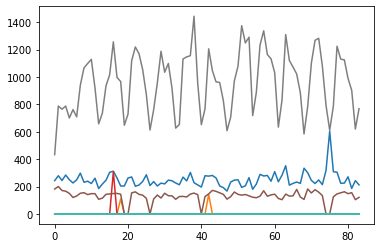

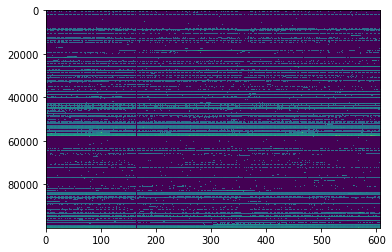

In [613]:
x = np.arange(train.shape[1])
for i in range(10):
    plt.plot(x, train[i])
plt.show()

plt.imshow(np.log(sample.sort_values(by=["sign_0", "inDegree"])[DATES].values+1), aspect="auto")
plt.show()

## Linear Regresion

In [614]:
train_std, _, _ = create_dataset(sample[DATES], 7, 14, standardize=True)
run_trial("linear regression with standardized", LinearRegression(), train_std, validate, test)

[{'mape': 1.4567511544260624e+17,
  'rmse': 2.8914364558401853e+18,
  'name': 'linear regression with standardized'}]

In [615]:
run_trial("linear regression", LinearRegression(), train, validate, test)

[{'mape': 76.8374122596817,
  'rmse': 480.3015906823932,
  'name': 'linear regression'}]

In [618]:
run_trial("linear regression with graph", LinearRegression(), train, validate, test, [sample[DEGREE+SIGN+VECTOR].fillna(0)])

[{'mape': 76.94396247117578,
  'rmse': 479.3602298893801,
  'name': 'linear regression with graph'}]

In [619]:
graph = scaler.fit_transform(sample[DEGREE+SIGN+VECTOR].fillna(0))
run_trial("linear regression with graph", LinearRegression(), train, validate, test, [graph])

[{'mape': 76.94510831461737,
  'rmse': 479.4412597491403,
  'name': 'linear regression with graph'}]

### Ridge

In [620]:
scoring = ["neg_mean_absolute_error", "neg_mean_squared_error"]
grid_ridge = GridSearchCV(
    estimator=Ridge(),
    param_grid={
        "alpha": [1e-3, 0, 1, 1e5, 1e8, 1e9, 1e10, 1e11, 1e12]
    },
    scoring=scoring,
    refit="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
)

%time print(run_trial("ridge regression", grid_ridge, train, validate, test, [graph]))
pd.DataFrame(grid_ridge.cv_results_)

[{'mape': 75.59227837306523, 'rmse': 426.7317688737503, 'name': 'ridge regression'}]
CPU times: user 1.25 s, sys: 465 ms, total: 1.71 s
Wall time: 4.64 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,0.819662,0.035552,0.154157,0.014100,0.001,{'alpha': 0.001},-47.152428,-44.705897,-48.748149,-46.868828,1.662374,6,-335810.247563,-440244.232386,-937045.997106,-571031.140119,262297.893574,9
1,1.606076,1.040137,0.130006,0.072552,0,{'alpha': 0},-47.152428,-44.717506,-48.748166,-46.872703,1.657348,7,-335810.247564,-440099.509659,-937046.498374,-570983.066781,262322.188138,8
2,0.820235,0.033806,0.158918,0.014380,1,{'alpha': 1},-47.152378,-44.705856,-48.731545,-46.863262,1.656139,5,-335810.246631,-440244.230398,-936575.825257,-570874.416763,262079.203632,7
3,0.843401,0.023422,0.140011,0.028113,100000,{'alpha': 100000.0},-45.748543,-43.753309,-48.268506,-45.923451,1.847457,4,-335816.803956,-440219.135074,-931550.071682,-569193.003118,259744.081762,6
4,0.759800,0.009092,0.076279,0.005279,1e+08,{'alpha': 100000000.0},-44.879770,-43.380507,-48.168750,-45.476336,1.999781,3,-320829.131522,-438144.871435,-925840.474609,-561602.418099,261968.562676,5
5,0.862575,0.077641,0.082178,0.027278,1e+09,{'alpha': 1000000000.0},-43.197785,-42.210060,-47.629331,-44.345714,2.356606,1,-271871.449984,-435817.110607,-896549.665774,-534743.446709,264443.958728,4
6,0.805103,0.045564,0.086798,0.003536,1e+10,{'alpha': 10000000000.0},-42.785730,-41.489842,-49.576079,-44.617199,3.546118,2,-193476.862891,-426042.953139,-798792.662914,-472768.033375,249318.621726,3
7,0.723299,0.231408,0.054113,0.009010,1e+11,{'alpha': 100000000000.0},-45.372524,-45.914935,-63.589585,-51.625619,8.462636,8,-131861.582241,-427398.867064,-677172.829416,-412141.623412,222884.193782,1
8,0.399759,0.006037,0.042162,0.004290,1e+12,{'alpha': 1000000000000.0},-85.607165,-82.990436,-115.715685,-94.771004,14.848494,9,-139507.519477,-428233.093507,-771630.256878,-446453.887127,258385.090503,2


### Lasso

In [624]:
scoring = ["neg_mean_absolute_error", "neg_mean_squared_error"]
grid_lasso = GridSearchCV(
    estimator=Lasso(),
    param_grid={
        "alpha": [1e-3, 0, 1, 1e3, 1e4, 1e5, 1e6, 1e9]
    },
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
)

%time res = run_trial("lasso regression", grid_lasso, train, validate, test, [graph])
print(res)
pd.DataFrame(grid_lasso.cv_results_)

CPU times: user 20.3 s, sys: 2.4 s, total: 22.7 s
Wall time: 6min 53s
[{'mape': 75.61959075128244, 'rmse': 435.6007983558474, 'name': 'lasso regression'}]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,359.715920,36.421777,0.020445,0.002624,0.001,{'alpha': 0.001},-335810.100878,-440244.182469,-9.363793e+05,-570808.829711,261987.826502,7
1,408.513143,0.812042,0.010580,0.000953,0,{'alpha': 0},-335810.247622,-440244.232388,-9.370465e+05,-571031.307227,262298.126714,8
2,275.655750,43.529897,0.023773,0.002703,1,{'alpha': 1},-335714.961159,-440210.295159,-9.312649e+05,-569061.043673,259643.432565,6
3,97.667981,18.884538,0.050514,0.006502,1000,{'alpha': 1000.0},-305916.246546,-433292.379782,-9.147216e+05,-551307.618925,262179.316937,4
4,52.914459,11.616228,0.050509,0.004478,10000,{'alpha': 10000.0},-284809.224963,-426843.200891,-9.034769e+05,-538373.906857,264596.656349,1
5,21.159692,11.658376,0.045329,0.005071,100000,{'alpha': 100000.0},-197519.713631,-438950.240251,-1.019897e+06,-552118.861892,345139.841427,5
6,2.806326,0.036182,0.047550,0.006451,1e+06,{'alpha': 1000000.0},-208542.727702,-489547.621011,-9.509443e+05,-549674.790995,306052.407110,2
7,2.867469,0.045078,0.055949,0.003109,1e+09,{'alpha': 1000000000.0},-211469.139305,-489547.621011,-9.509443e+05,-550650.281039,304966.288530,3


## Neural Network

In [621]:
train.shape, graph.shape

((100000, 84), (100000, 19))

In [628]:
scoring = ["neg_mean_absolute_error", "neg_mean_squared_error"]
param_grid = {
    "learning_rate_init": [1e-3],
    "activation": ["logistic"],
    "alpha": [1e-4, 1e-2],
    "hidden_layer_sizes": [
        (64,),
        (96,),
        (128,),
        (256,),
        (64, 64)
    ]
}
grid_nn = GridSearchCV(
    estimator=MLPRegressor(solver="sgd"),
    param_grid=param_grid,
    scoring=scoring,
    refit="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
)


res = run_trial("neural network", grid_nn, train, validate, test, [graph])
print(res)
pd.DataFrame(grid_nn.cv_results_)

[{'mape': 92.73929967580582, 'rmse': 567.971608833118, 'name': 'neural network'}]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate_init,params,split0_test_neg_mean_absolute_error,...,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error,split1_test_neg_mean_squared_error,split2_test_neg_mean_squared_error,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error
0,25.297168,4.419455,0.171213,0.004304,logistic,0.0001,"(64,)",0.001,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",-117.967448,...,-127.202279,-121.396460,4.127720,5,-194837.412209,-475613.058407,-933144.926417,-534528.402067,304278.821660,7
1,32.265935,10.049934,0.232439,0.009887,logistic,0.0001,"(96,)",0.001,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",-120.605195,...,-122.355818,-118.168412,4.738236,4,-193027.192086,-472570.198179,-931312.835140,-532300.015707,304349.363043,3
2,53.487169,15.148551,0.332296,0.042247,logistic,0.0001,"(128,)",0.001,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",-114.084606,...,-118.565839,-115.388784,2.258464,3,-193918.068701,-472437.607614,-931771.641071,-532705.717885,304227.762313,4
3,54.411466,26.524997,0.536924,0.069892,logistic,0.0001,"(256,)",0.001,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",-116.667498,...,-136.575180,-122.774311,9.780100,7,-192431.494297,-470492.706638,-933861.203111,-532258.403046,305822.822798,2
4,38.733699,10.107023,0.302163,0.011313,logistic,0.0001,"(64, 64)",0.001,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",-128.384988,...,-136.588551,-132.949819,3.412538,9,-204145.646948,-482610.517736,-943084.853983,-543276.948209,304706.132601,10
5,15.863194,3.616607,0.156911,0.013560,logistic,0.01,"(64,)",0.001,"{'activation': 'logistic', 'alpha': 0.01, 'hid...",-128.065859,...,-131.346687,-124.897438,6.931377,8,-198420.910004,-472850.580177,-937721.136020,-536327.496301,305138.037674,8
6,24.590749,11.424147,0.228493,0.008750,logistic,0.01,"(96,)",0.001,"{'activation': 'logistic', 'alpha': 0.01, 'hid...",-126.702299,...,-124.869087,-122.246757,5.060516,6,-195140.019586,-471720.818426,-934682.647878,-533844.441552,305096.676901,6
7,22.175867,2.332454,0.293940,0.029840,logistic,0.01,"(128,)",0.001,"{'activation': 'logistic', 'alpha': 0.01, 'hid...",-110.703979,...,-117.603754,-115.120342,3.130958,2,-194101.372852,-472767.689300,-933657.995047,-533505.624990,304962.800058,5
8,33.592333,7.653233,0.387989,0.095121,logistic,0.01,"(256,)",0.001,"{'activation': 'logistic', 'alpha': 0.01, 'hid...",-111.220865,...,-118.871718,-112.148030,5.153194,1,-191399.849439,-470666.502597,-930217.693326,-530757.954839,304600.098760,1
9,27.050544,1.079407,0.233512,0.021260,logistic,0.01,"(64, 64)",0.001,"{'activation': 'logistic', 'alpha': 0.01, 'hid...",-130.640572,...,-137.053991,-133.055840,2.847452,10,-204091.710390,-482487.580720,-943038.899886,-543202.672522,304714.204950,9


In [627]:
import itertools

res = []
features = [("degree", sample[DEGREE]), ("sign", sample[SIGN]), ("vector", sample[VECTOR])]
for pair in itertools.combinations(features, 2):
    name, feat = zip(*pair)
    names = " + ".join(name)
    feat = [scaler.fit_transform(f) for f in feat]
    res += run_trial(f"neural network ({names})", grid_nn.best_estimator_, train, validate, test, feat)
    print(names)
    print(pd.DataFrame(grid_nn.cv_results_).sort_values("rank_test_neg_mean_squared_error").loc[0, ["params"]])
pd.DataFrame(res)

degree + sign
mean_fit_time                                                                     10.854
std_fit_time                                                                     4.43797
mean_score_time                                                                   0.3435
std_score_time                                                                  0.015492
param_activation                                                                logistic
param_alpha                                                                       0.0001
param_hidden_layer_sizes                                                           (64,)
param_learning_rate_init                                                           0.001
params                                 {'activation': 'logistic', 'alpha': 0.0001, 'h...
split0_test_neg_mean_absolute_error                                              -137.97
split1_test_neg_mean_absolute_error                                             -114.894
split2_

,mape,rmse,name
0,88.799501,572.616629,neural network (degree + sign)
1,85.701243,572.229460,neural network (degree + vector)
2,84.666674,571.390957,neural network (sign + vector)
